In [1]:
import os
import datetime
import glob
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
exchange_path = sorted(glob.glob('./../data/exchange/*'))
exchange = pd.read_csv(exchange_path[5])
exchange_CAD = exchange.iloc[22:]
exchange_CAD = exchange_CAD.reset_index().drop('index', axis = 1)
exchange_CAD = exchange_CAD.drop('Unnamed: 0', axis = 1)
exchange_CAD

,date,buy,standard
0,2022-03-31,986.89,970.15
1,2022-03-30,988.16,976.56
2,2022-03-29,993.60,979.11
3,2022-03-28,1000.83,975.93
4,2022-03-25,990.37,973.30
...,...,...,...
4595,2003-09-30,869.25,850.17
4596,2003-09-29,862.23,850.62
4597,2003-09-26,867.33,853.30
4598,2003-09-25,870.15,853.83


In [3]:
exchange_CAD['ex'] = np.log(exchange_CAD['buy']) # % 데이터
exchange_CAD['ex'].isnull().sum()
exchange_CAD

,date,buy,standard,ex
0,2022-03-31,986.89,970.15,6.894559
1,2022-03-30,988.16,976.56,6.895845
2,2022-03-29,993.60,979.11,6.901335
3,2022-03-28,1000.83,975.93,6.908585
4,2022-03-25,990.37,973.30,6.898079
...,...,...,...,...
4595,2003-09-30,869.25,850.17,6.767631
4596,2003-09-29,862.23,850.62,6.759522
4597,2003-09-26,867.33,853.30,6.765420
4598,2003-09-25,870.15,853.83,6.768666


In [4]:
import datetime
exchange_CAD['dt'] = pd.to_datetime(exchange_CAD['date'])
exchange_CAD['dt'] = exchange_CAD['dt'].dt.strftime('%Y-%m')
exchange_CAD

,date,buy,standard,ex,dt
0,2022-03-31,986.89,970.15,6.894559,2022-03
1,2022-03-30,988.16,976.56,6.895845,2022-03
2,2022-03-29,993.60,979.11,6.901335,2022-03
3,2022-03-28,1000.83,975.93,6.908585,2022-03
4,2022-03-25,990.37,973.30,6.898079,2022-03
...,...,...,...,...,...
4595,2003-09-30,869.25,850.17,6.767631,2003-09
4596,2003-09-29,862.23,850.62,6.759522,2003-09
4597,2003-09-26,867.33,853.30,6.765420,2003-09
4598,2003-09-25,870.15,853.83,6.768666,2003-09


In [5]:
interest_path = sorted(glob.glob('./../data/interest/*'))
interest_path[-2]

'./../data/interest/40_south-korea_government_bond_rate_1year.csv'

In [6]:
interest_path = sorted(glob.glob('./../data/interest/*'))
interest_Canada = pd.read_csv(interest_path[3])
interest_Korea = pd.read_csv(interest_path[-2])
interest_CAD = interest_Canada.iloc[26:]
interest_KOR = interest_Korea.iloc[49:-658]
interest_CAD, interest_KOR

(      Unnamed: 0        date  interest  change
 26            26  2022-03-31      1.96   -1.01
 27            27  2022-03-30      1.98    6.45
 28            28  2022-03-29      1.86    0.54
 29            29  2022-03-28      1.85    1.09
 30            30  2022-03-25      1.83    5.78
 ...          ...         ...       ...     ...
 5072        4995  2003-09-30      2.59   -2.26
 5073        4996  2003-09-29      2.65    1.15
 5074        4997  2003-09-26      2.62   -0.38
 5075        4998  2003-09-25      2.63    0.38
 5076        4999  2003-09-24      2.62   -0.38
 
 [5051 rows x 4 columns],
       Unnamed: 0        date  interest  change
 49            49  2022-03-31     1.675    1.39
 50            50  2022-03-30     1.652   -0.12
 51            51  2022-03-29     1.654   -0.36
 52            52  2022-03-28     1.660    6.14
 53            53  2022-03-27     1.564    0.00
 ...          ...         ...       ...     ...
 4780        4337  2003-12-12     4.640   -0.43
 4781       

In [7]:
start_date = pd.to_datetime(exchange_CAD.iloc[-1,0]) ## 시작 날짜
end_date = pd.to_datetime(exchange_CAD.iloc[0,0]) ## 마지막 날짜
 
dates = pd.date_range(start_date,end_date,freq='D')
padding = pd.DataFrame({'date' : dates})
padding = padding.sort_values(by = 'date', ascending = False).reset_index().drop('index', axis = 1)
padding['date'] = padding['date'].dt.strftime('%Y-%m-%d')
padding

,date
0,2022-03-31
1,2022-03-30
2,2022-03-29
3,2022-03-28
4,2022-03-27
...,...
6759,2003-09-28
6760,2003-09-27
6761,2003-09-26
6762,2003-09-25


In [8]:
interest_CAD_r = interest_CAD[['date', 'interest']]
interest_CAD_r = interest_CAD_r.rename(columns = {'interest' : 'int_CAD'})

interest_KOR_r = interest_KOR[['date', 'interest']]
interest_KOR_r = interest_KOR_r.rename(columns = {'interest' : 'int_KOR'})

In [9]:
padding_temp = pd.merge(padding,interest_CAD_r, on = 'date', how = 'outer')
padding_temp

,date,int_CAD
0,2022-03-31,1.96
1,2022-03-30,1.98
2,2022-03-29,1.86
3,2022-03-28,1.85
4,2022-03-27,NaN
...,...,...
6759,2003-09-28,NaN
6760,2003-09-27,NaN
6761,2003-09-26,2.62
6762,2003-09-25,2.63


In [10]:
padding_merge = pd.merge(padding_temp,interest_KOR_r, on = 'date', how = 'outer')
padding_merge

,date,int_CAD,int_KOR
0,2022-03-31,1.96,1.675
1,2022-03-30,1.98,1.652
2,2022-03-29,1.86,1.654
3,2022-03-28,1.85,1.660
4,2022-03-27,NaN,1.564
...,...,...,...
6760,2003-09-27,NaN,NaN
6761,2003-09-26,2.62,NaN
6762,2003-09-25,2.63,NaN
6763,2003-09-24,2.62,NaN


In [11]:
padding_null = padding_merge.notnull()
padding_null

,date,int_CAD,int_KOR
0,True,True,True
1,True,True,True
2,True,True,True
3,True,True,True
4,True,False,True
...,...,...,...
6760,True,False,False
6761,True,True,False
6762,True,True,False
6763,True,True,False


In [12]:
# for i in range(len(padding_merge)-2,-1,-1):
if not padding_null['int_KOR'][6763]:
    print('널값이다!')

널값이다!


In [13]:
for i in range(len(padding_merge)-2,-1,-1): # 6763부터 시작
    if not padding_null['int_CAD'][i]:
        padding_merge['int_CAD'][i] = padding_merge['int_CAD'][i+1]
    if not padding_null['int_KOR'][i]:
        padding_merge['int_KOR'][i] = padding_merge['int_KOR'][i+1]
padding_merge

/var/folders/v0/twgc0q1d1qnc66ygdv3d817r0000gn/T/ipykernel_64451/3194149557.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  padding_merge['int_KOR'][i] = padding_merge['int_KOR'][i+1]
/var/folders/v0/twgc0q1d1qnc66ygdv3d817r0000gn/T/ipykernel_64451/3194149557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  padding_merge['int_CAD'][i] = padding_merge['int_CAD'][i+1]


,date,int_CAD,int_KOR
0,2022-03-31,1.96,1.675
1,2022-03-30,1.98,1.652
2,2022-03-29,1.86,1.654
3,2022-03-28,1.85,1.660
4,2022-03-27,1.83,1.564
...,...,...,...
6760,2003-09-27,2.62,4.140
6761,2003-09-26,2.62,4.140
6762,2003-09-25,2.63,4.140
6763,2003-09-24,2.62,4.140


In [14]:
padding_merge['int_spread'] = padding_merge['int_KOR'] - padding_merge['int_CAD']
padding_merge

,date,int_CAD,int_KOR,int_spread
0,2022-03-31,1.96,1.675,-0.285
1,2022-03-30,1.98,1.652,-0.328
2,2022-03-29,1.86,1.654,-0.206
3,2022-03-28,1.85,1.660,-0.190
4,2022-03-27,1.83,1.564,-0.266
...,...,...,...,...
6760,2003-09-27,2.62,4.140,1.520
6761,2003-09-26,2.62,4.140,1.520
6762,2003-09-25,2.63,4.140,1.510
6763,2003-09-24,2.62,4.140,1.520


In [15]:
exchange_CAD

,date,buy,standard,ex,dt
0,2022-03-31,986.89,970.15,6.894559,2022-03
1,2022-03-30,988.16,976.56,6.895845,2022-03
2,2022-03-29,993.60,979.11,6.901335,2022-03
3,2022-03-28,1000.83,975.93,6.908585,2022-03
4,2022-03-25,990.37,973.30,6.898079,2022-03
...,...,...,...,...,...
4595,2003-09-30,869.25,850.17,6.767631,2003-09
4596,2003-09-29,862.23,850.62,6.759522,2003-09
4597,2003-09-26,867.33,853.30,6.765420,2003-09
4598,2003-09-25,870.15,853.83,6.768666,2003-09


In [16]:
inflation_Canada = pd.read_excel('./../data/2차/inflation/inflation.xlsx')
data = inflation_Canada.iloc[3, 646:]
index = inflation_Canada.iloc[1, 646:]
index = inflation_Canada.iloc[1, 646:]

In [17]:
inflation_Korea = pd.read_excel('./../data/1차/imf 한미일 물가 지수.xlsx')
inf_KOR = inflation_Korea.iloc[5, 56:].values
b = inf_KOR[1:]
a = inf_KOR[ :len(inf_KOR)-1]
inf_KOR = (b-a)/a*100

In [18]:
liquidity_KOR = pd.read_excel('./../data/2차/Liquidity/korea_Liquidity.xlsx')
liquidity_KOR = liquidity_KOR.iloc[[6,7], 13:len(liquidity_KOR.columns) - 1]
li_KOR = liquidity_KOR.iloc[1].to_list()
li_KOR

[141472.189771548,
 143245.490267055,
 150272.828764654,
 155284.24111768702,
 157374.510530651,
 162935.078208282,
 163487.807592362,
 163568.789329762,
 166471.298234626,
 166957.734729665,
 167935.494449158,
 170421.19417898098,
 174376.151349565,
 178318.745973532,
 192532.20980153,
 198996.564800159,
 199625.684515137,
 202093.06654135,
 205375.03186027898,
 206304.69255837,
 206021.95207310998,
 204911.306474646,
 205611.839647257,
 206638.51974954997,
 206657.019466307,
 207230.74142497798,
 208155.722552622,
 210317.17683875,
 216859.72142311,
 215876.373989849,
 217270.52530455898,
 222817.822180379,
 224615.952178142,
 225641.855932564,
 225642.881954724,
 226951.08029103602,
 228149.3799656,
 229385.680228459,
 234183.30379193398,
 238882.310981532,
 240154.123618926,
 242737.577724628,
 243840.324670402,
 247185.053336666,
 250667.086628462,
 250627.710226456,
 254764.451034495,
 255228.015860249,
 257219.90224469,
 260064.838950044,
 261853.737593423,
 262150.152963913,
 2

In [19]:
liquidity_CAD = pd.read_excel('./../data/2차/Liquidity/canada_Liquidity.xlsx')
liquidity_CAD = liquidity_CAD.iloc[[6,7], 49:]
li_CAD = liquidity_CAD.iloc[1].to_list()
li_CAD

[36610.7230791447,
 35788.5922638138,
 36054.079623491096,
 36222.1007993034,
 36323.4155511149,
 35938.921517608396,
 36365.514774029405,
 35064.3562519509,
 35933.2672193344,
 35373.481271214405,
 35154.463410332,
 35843.575708309196,
 36215.2515931239,
 36413.990601160105,
 34032.191900559395,
 34428.643087875396,
 34544.3325654839,
 35514.502489482904,
 36199.3982172264,
 35556.385119772596,
 34989.561274412205,
 34876.105243225305,
 33282.6689654371,
 34251.748995632195,
 33547.292849792,
 34163.3680999335,
 34144.8671152696,
 32962.124276077,
 32896.903204591705,
 32623.387772995997,
 35966.2632597398,
 35645.983310801596,
 35613.0054447953,
 35845.663402193,
 36321.8375346482,
 35785.116344599504,
 35952.397829729794,
 35576.4359380041,
 36407.7520693555,
 34993.800647193704,
 35836.7918777717,
 36237.4695046624,
 39230.5962169836,
 40109.021411729205,
 40024.26189219081,
 39341.2475713,
 40229.9041147071,
 40228.380573019,
 40900.1942855364,
 40711.5495182959,
 40767.405923417,

In [20]:
date = liquidity_CAD.iloc[0, :]
li_df = pd.DataFrame({'date' : date, 'li_CAD': li_CAD, 'li_KOR':li_KOR})
li_df['li_CAD'] = np.log(li_df['li_CAD'])
li_df['li_KOR'] = np.log(li_df['li_KOR'])
li_df['li_spread'] = li_df['li_KOR'] - li_df['li_CAD']
li_df

,date,li_CAD,li_KOR,li_spread
Unnamed: 49,2003M09,10.508096,11.859858,1.351762
Unnamed: 50,2003M10,10.485384,11.872315,1.386931
Unnamed: 51,2003M11,10.492775,11.920208,1.427432
Unnamed: 52,2003M12,10.497425,11.953013,1.455588
Unnamed: 53,2004M01,10.500218,11.966384,1.466166
...,...,...,...,...
Unnamed: 267,2021M11,11.548549,13.034616,1.486067
Unnamed: 268,2021M12,11.576981,13.032809,1.455829
Unnamed: 269,2022M01,11.556006,13.029335,1.473329
Unnamed: 270,2022M02,11.541408,13.029883,1.488475


In [21]:
monthly = pd.DataFrame({'index' : index, 'inf_CAD': data, 'inf_KOR' : inf_KOR})
monthly['dt'] = monthly['index'].str[:4] + '-' + monthly['index'].str[5:]
monthly['dt'] = pd.to_datetime(monthly['dt'])
monthly['dt'] = monthly['dt'].dt.strftime('%Y-%m')
monthly['inf_spread'] = monthly['inf_KOR'] - monthly['inf_CAD']
monthly['m1_spread'] = li_df['li_spread'].values
monthly

,index,inf_CAD,inf_KOR,dt,inf_spread,m1_spread
Unnamed: 646,2003M09,0.194363,0.904861,2003-09,0.710497,1.351762
Unnamed: 647,2003M10,-0.29098,0.087972,2003-10,0.378952,1.386931
Unnamed: 648,2003M11,0.291829,-0.178625,2003-11,-0.470453,1.427432
Unnamed: 649,2003M12,0.096993,0.450201,2003-12,0.353208,1.455588
Unnamed: 650,2004M01,0.096899,0.624912,2004-01,0.528012,1.466166
...,...,...,...,...,...,...
Unnamed: 864,2021M11,0.208478,0.503145,2021-11,0.294667,1.486067
Unnamed: 865,2021M12,-0.138696,0.163666,2021-12,0.302362,1.455829
Unnamed: 866,2022M01,0.902778,0.62476,2022-01,-0.278018,1.473329
Unnamed: 867,2022M02,1.032347,0.582673,2022-02,-0.449674,1.488475


In [22]:
inflation_spread_list = monthly['inf_spread'].to_list()
liquidity_spread_list = monthly['m1_spread'].to_list()
monthly_index_list = monthly['dt'].to_list()
exchange_CAD['inf_spread'] = 'nan'
exchange_CAD['m1_spread'] = 'nan'
for i in range(len(exchange_CAD)):
    try:
        exchange_CAD['inf_spread'][i] = inflation_spread_list[monthly_index_list.index(exchange_CAD.iloc[i,4])]
        exchange_CAD['m1_spread'][i] = liquidity_spread_list[monthly_index_list.index(exchange_CAD.iloc[i,4])]
    except: print(f'{i}외왆되?')
exchange_CAD

/var/folders/v0/twgc0q1d1qnc66ygdv3d817r0000gn/T/ipykernel_64451/1274888129.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exchange_CAD['inf_spread'][i] = inflation_spread_list[monthly_index_list.index(exchange_CAD.iloc[i,4])]
/var/folders/v0/twgc0q1d1qnc66ygdv3d817r0000gn/T/ipykernel_64451/1274888129.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exchange_CAD['m1_spread'][i] = liquidity_spread_list[monthly_index_list.index(exchange_CAD.iloc[i,4])]


,date,buy,standard,ex,dt,inf_spread,m1_spread
0,2022-03-31,986.89,970.15,6.894559,2022-03,-0.70877,1.471268
1,2022-03-30,988.16,976.56,6.895845,2022-03,-0.70877,1.471268
2,2022-03-29,993.60,979.11,6.901335,2022-03,-0.70877,1.471268
3,2022-03-28,1000.83,975.93,6.908585,2022-03,-0.70877,1.471268
4,2022-03-25,990.37,973.30,6.898079,2022-03,-0.70877,1.471268
...,...,...,...,...,...,...,...
4595,2003-09-30,869.25,850.17,6.767631,2003-09,0.710497,1.351762
4596,2003-09-29,862.23,850.62,6.759522,2003-09,0.710497,1.351762
4597,2003-09-26,867.33,853.30,6.765420,2003-09,0.710497,1.351762
4598,2003-09-25,870.15,853.83,6.768666,2003-09,0.710497,1.351762


In [23]:
left = exchange_CAD[['date', 'ex', 'inf_spread', 'm1_spread']]
right = padding_merge[['date', 'int_spread']]
df = pd.merge(left,right, on = 'date', how = 'left', sort = True)
df

,date,ex,inf_spread,m1_spread,int_spread
0,2003-09-24,6.763134,0.710497,1.351762,1.520
1,2003-09-25,6.768666,0.710497,1.351762,1.510
2,2003-09-26,6.765420,0.710497,1.351762,1.520
3,2003-09-29,6.759522,0.710497,1.351762,1.490
4,2003-09-30,6.767631,0.710497,1.351762,1.550
...,...,...,...,...,...
4595,2022-03-25,6.898079,-0.70877,1.471268,-0.266
4596,2022-03-28,6.908585,-0.70877,1.471268,-0.190
4597,2022-03-29,6.901335,-0.70877,1.471268,-0.206
4598,2022-03-30,6.895845,-0.70877,1.471268,-0.328


In [24]:
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d')
df = df.astype('float')

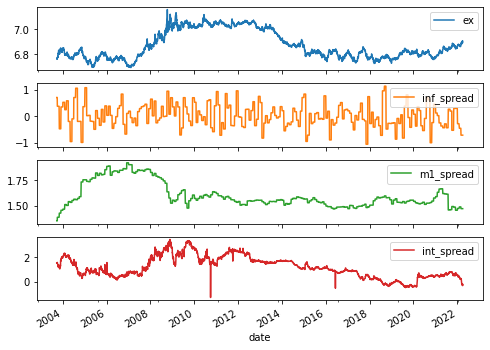

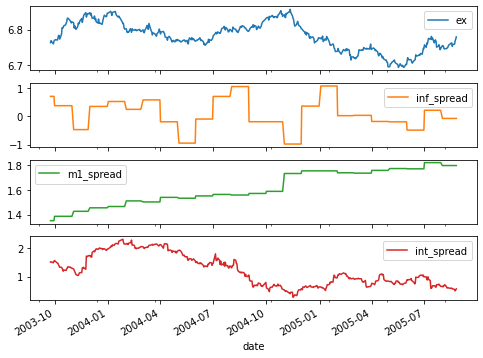

In [25]:
plot_cols = ['ex', 'inf_spread', 'm1_spread', 'int_spread']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [48]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ex,4600.0,6.871071,0.113280,6.691426,6.781441,6.825096,7.005134,7.160147
inf_spread,4600.0,0.022548,0.440031,-1.049890,-0.268934,-0.015028,0.353143,1.135684
m1_spread,4600.0,1.601227,0.121863,1.351762,1.523468,1.558179,1.622234,1.920800
int_spread,4600.0,1.163182,0.861470,-1.300000,0.507750,1.042000,1.723000,3.450000


In [49]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
column_indices, num_features

({'ex': 0, 'inf_spread': 1, 'm1_spread': 2, 'int_spread': 3}, 4)

In [50]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

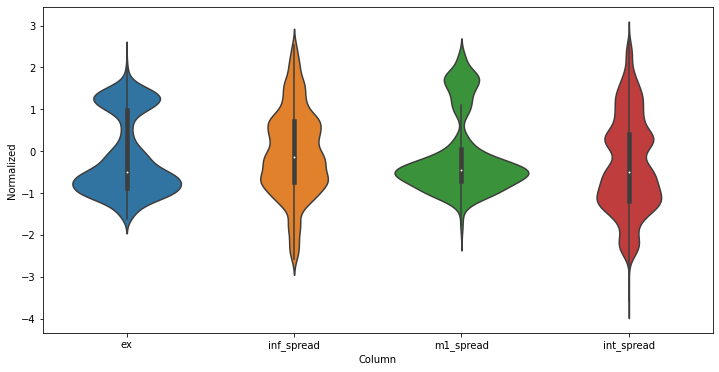

In [51]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys())

In [126]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [127]:
w1 = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                     input_width=25, label_width=1, shift=25,
                     label_columns=['ex'])
w1

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [49]
Label column name(s): ['ex']

In [128]:
w2 = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                     input_width=5, label_width=1, shift=1,
                     label_columns=['ex'])
w2

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['ex']

In [129]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] 
             for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [131]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[1000:1000+w2.total_window_size]),
                           np.array(train_df[3000:3000+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 6, 4)
Inputs shape: (3, 5, 4)
Labels shape: (3, 1, 1)


In [132]:
w2.example = example_inputs, example_labels

In [133]:
def plot(self, model=None, plot_col='ex', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

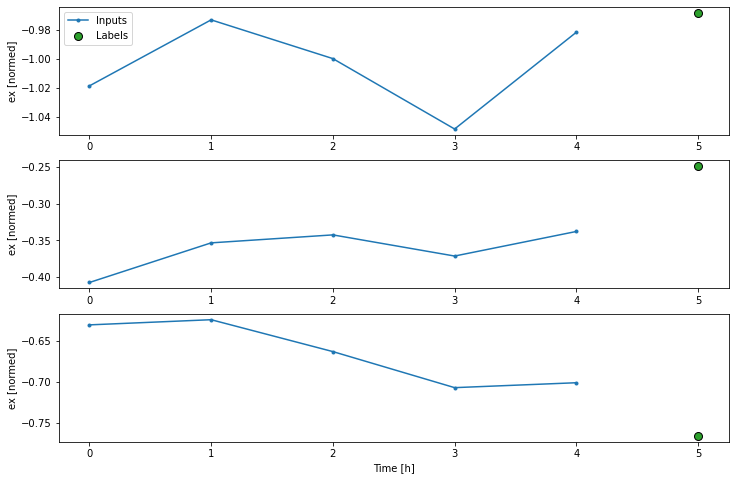

In [134]:
w2.plot()

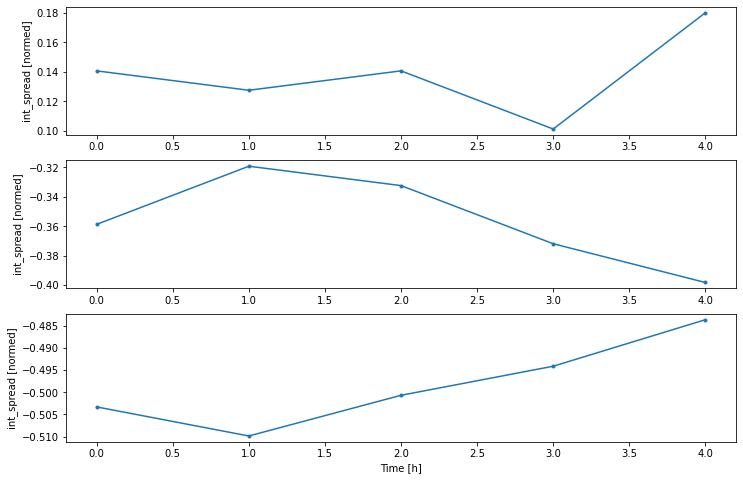

In [135]:
w2.plot(plot_col='int_spread')

In [177]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=25,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [178]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [179]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 5, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [180]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (25, 5, 4)
Labels shape (batch, time, features): (25, 1, 1)


In [181]:
val_performance = {}
performance = {}
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [182]:
CONV_WIDTH = 5
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ex'])

conv_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['ex']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

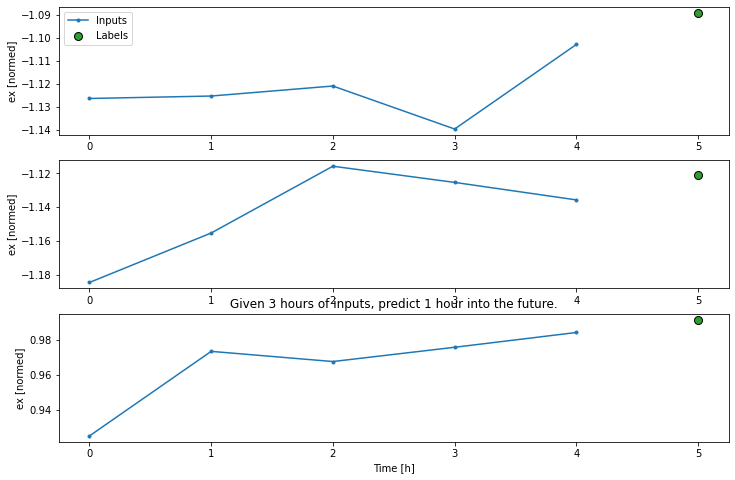

In [183]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [184]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='tanh'),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=1),
])

In [185]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (25, 5, 4)
Output shape: (25, 1, 1)


In [186]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

19/19 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0375


In [187]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (16, 50, 4)
Labels shape: (16, 50, 4)
Output shape: (16, 46, 1)


In [188]:
LABEL_WIDTH = 5
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ex'])

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [5 6 7 8 9]
Label column name(s): ['ex']

In [189]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (25, 9, 4)
Labels shape: (25, 5, 1)
Output shape: (25, 5, 1)


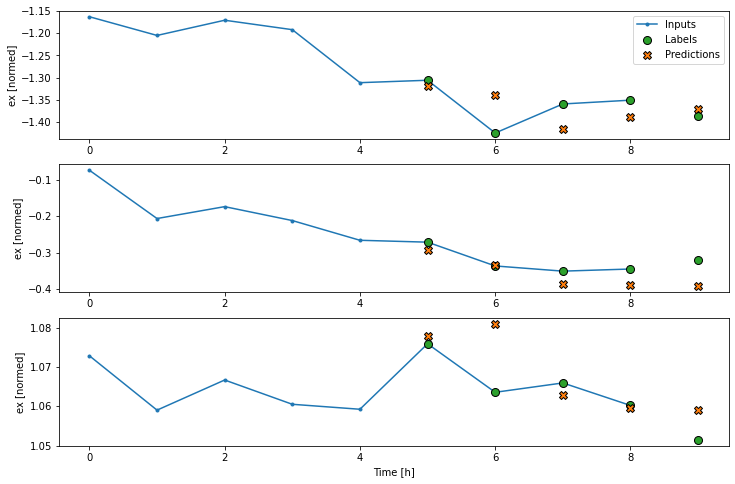

In [190]:
wide_conv_window.plot(conv_model)

In [191]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [192]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (16, 50, 4)
Output shape: (16, 50, 1)


In [193]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

17/17 [==============================] - 0s 16ms/step - loss: 0.7862 - mean_absolute_error: 0.6851


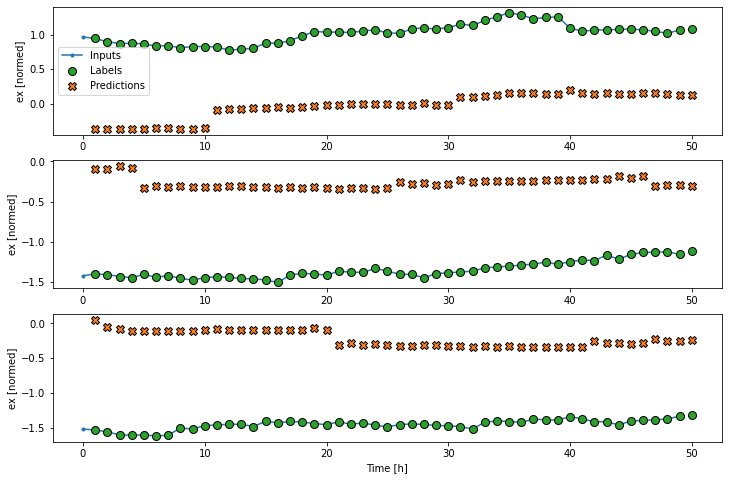

In [194]:
wide_window.plot(lstm_model)

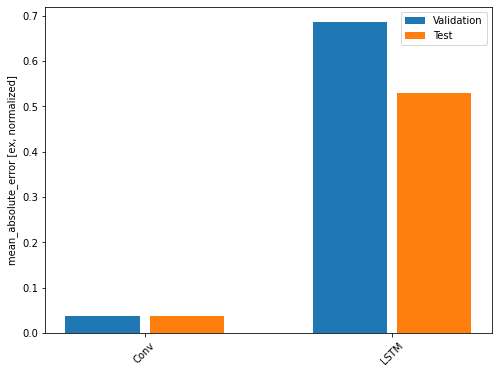

In [195]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [ex, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [196]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Conv        : 0.0384
LSTM        : 0.5292


In [197]:
wide_window = WindowGenerator(
    input_width=25, label_width=25, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (25, 25, 4)
Labels shape (batch, time, features): (25, 25, 4)


In [198]:
val_performance = {}
performance = {}

In [199]:
%%time
wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

17/17 [==============================] - 0s 10ms/step - loss: 0.0368 - mean_absolute_error: 0.0718

CPU times: user 59.4 s, sys: 19.8 s, total: 1min 19s
Wall time: 1min 1s


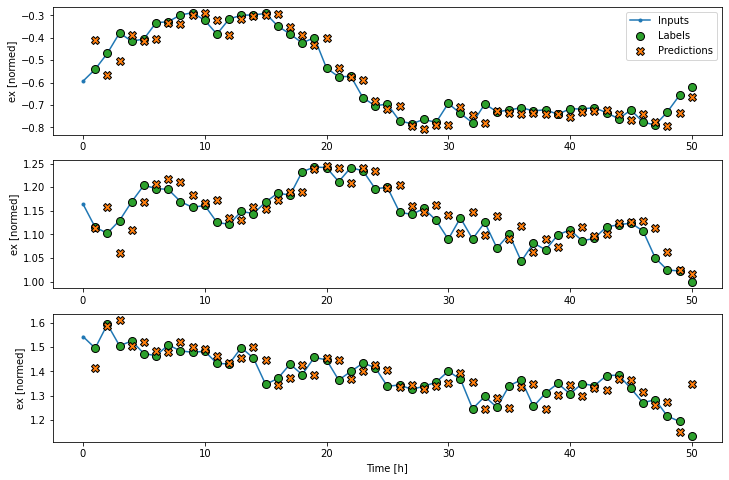

In [200]:
wide_window.plot(lstm_model)

In [201]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
        return inputs + delta

In [202]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32,activation='tanh', return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

17/17 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_absolute_error: 0.0506

CPU times: user 9.4 s, sys: 3.51 s, total: 12.9 s
Wall time: 16.1 s


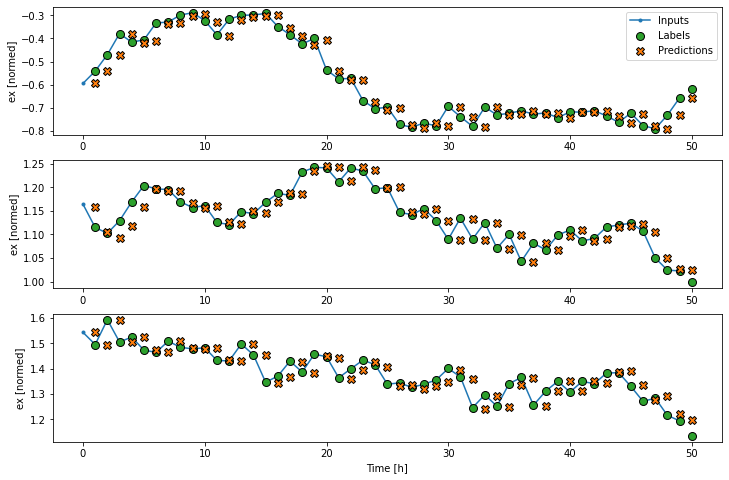

In [203]:
wide_window.plot(residual_lstm)

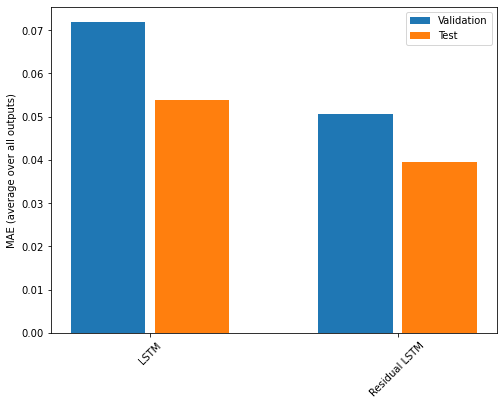

In [204]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [205]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

LSTM           : 0.0539
Residual LSTM  : 0.0395


Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Label column name(s): None

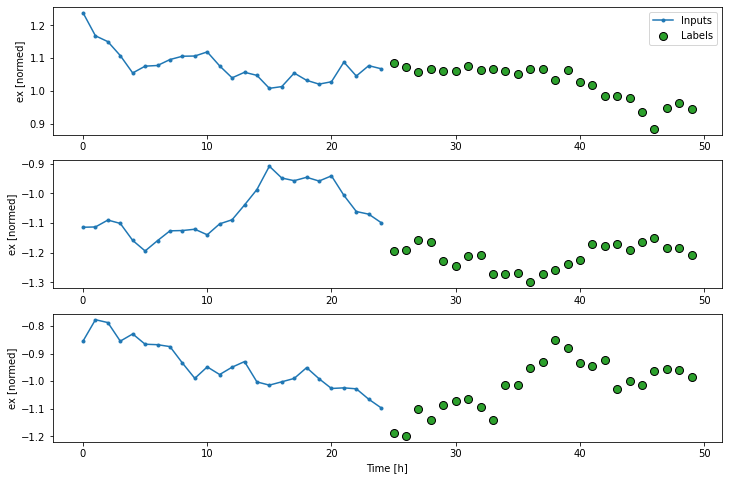

In [206]:
multi_val_performance = {}
multi_performance = {}
OUT_STEPS = 25
multi_window = WindowGenerator(input_width=25,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

17/17 [==============================] - 0s 6ms/step - loss: 0.3464 - mean_absolute_error: 0.3798


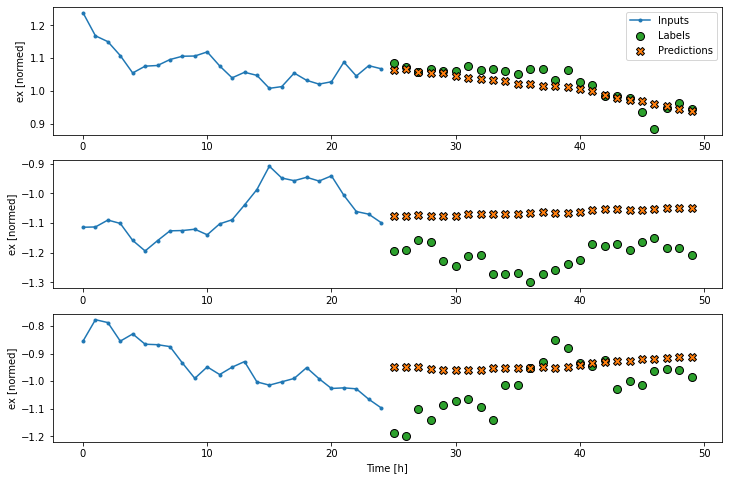

In [207]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [208]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)

        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [209]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [210]:
def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)

    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [211]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([25, 4])

In [212]:
def call(self, inputs, training=None):
    predictions = []
    prediction, state = self.warmup(inputs)

    predictions.append(prediction)

    for n in range(1, self.out_steps):
        x = prediction
        x, state = self.lstm_cell(x, states=state,
                              training=training)
        prediction = self.dense(x)
        predictions.append(prediction)

    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [213]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (25, 25, 4)


17/17 [==============================] - 1s 63ms/step - loss: 0.5830 - mean_absolute_error: 0.5526


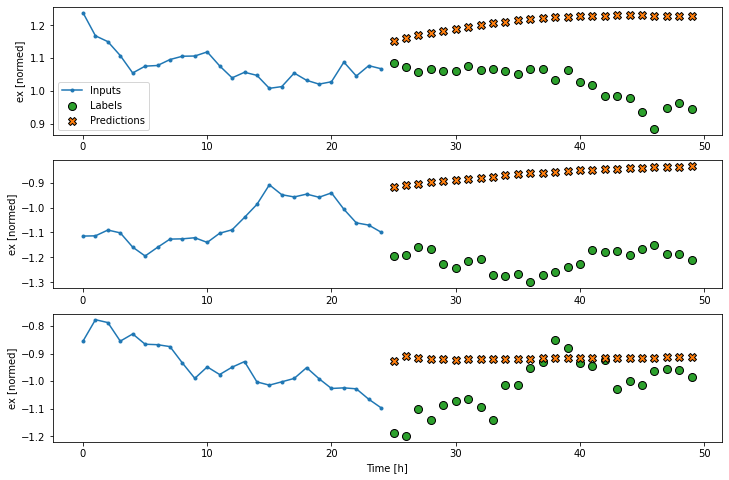

In [214]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

17/17 [==============================] - 0s 4ms/step - loss: 0.2188 - mean_absolute_error: 0.2681


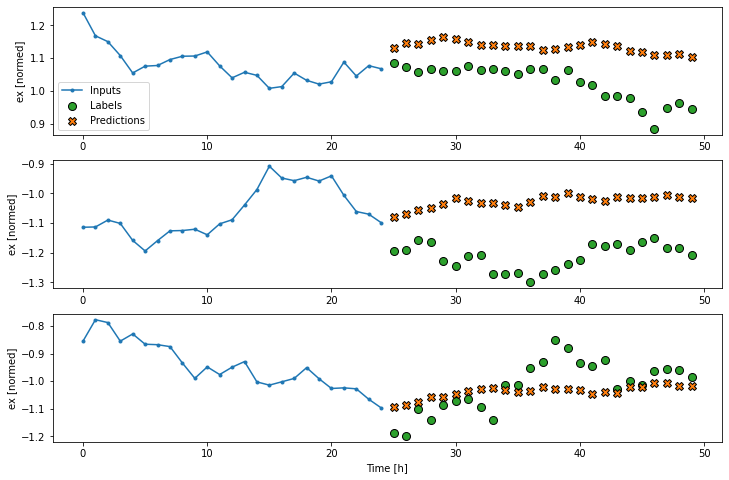

In [215]:
CONV_WIDTH = 5
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='tanh', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

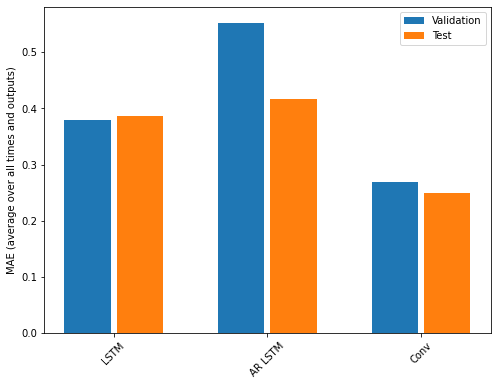

In [216]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [217]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

LSTM    : 0.3856
AR LSTM : 0.4159
Conv    : 0.2495
